## Task B.1

Time Step 0: Ocean currents updated.
Time Step 8: Ocean currents updated.
Time Step 16: Ocean currents updated.
Time Step 24: Ocean currents updated.
Time Step 32: Ocean currents updated.
Time Step 40: Ocean currents updated.
Time Step 48: Ocean currents updated.
Time Step 56: Ocean currents updated.
Time Step 64: Ocean currents updated.
Time Step 72: Ocean currents updated.
Time Step 80: Ocean currents updated.
Time Step 88: Ocean currents updated.
Time Step 96: Ocean currents updated.
Time Step 99: Ocean currents updated.
Execution time: 5.83 seconds


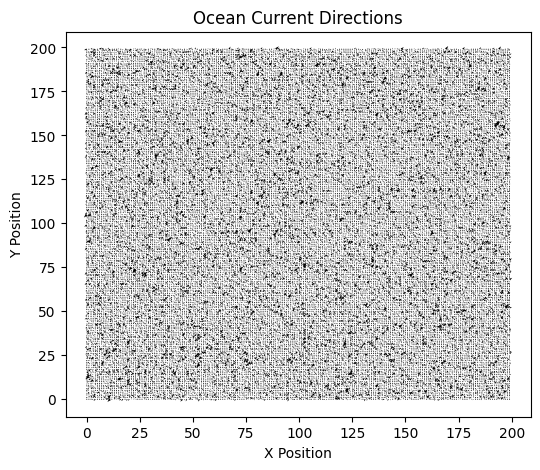

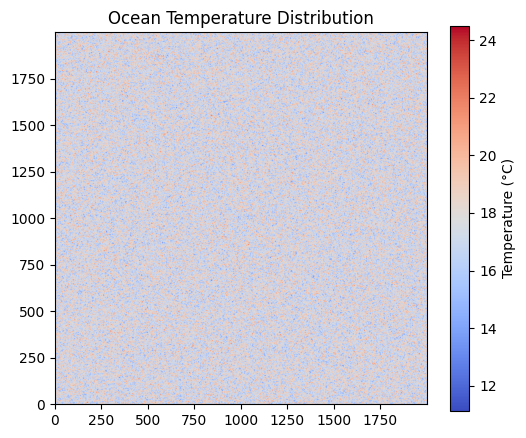

Simulation complete.


In [17]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Grid size
grid_size = 2000
TIME_STEPS = 100

# Initialize temperature field (random values between 5C and 30C)
temperature = np.random.uniform(5, 30, size=(grid_size, grid_size))

# Initialize velocity fields (u: x-direction, v: y-direction)
u_velocity = np.random.uniform(-1, 1, size=(grid_size, grid_size))
v_velocity = np.random.uniform(-1, 1, size=(grid_size, grid_size))

# Initialize wind influence (adds turbulence)
wind = np.random.uniform(-0.5, 0.5, size=(grid_size, grid_size))

def laplacian(field):
    """Computes the discrete Laplacian of a 2D field using finite differences."""
    lap = (
        np.roll(field, shift=1, axis=0) +
        np.roll(field, shift=-1, axis=0) +
        np.roll(field, shift=1, axis=1) +
        np.roll(field, shift=-1, axis=1) -
        4 * field
    )
    return lap

def update_ocean(u, v, temperature, wind, alpha=0.1, beta=0.02):
    """Updates ocean velocity and temperature fields using a simplified flow model."""
    u_new = u + alpha * laplacian(u) + beta * wind
    v_new = v + alpha * laplacian(v) + beta * wind
    temperature_new = temperature + 0.01 * laplacian(temperature)  # Small diffusion
    return u_new, v_new, temperature_new

# Run the simulation
start = time.time()
for t in range(TIME_STEPS):
    u_velocity, v_velocity, temperature = update_ocean(u_velocity, v_velocity, temperature, wind)
    if t % 8 == 0 or t == TIME_STEPS - 1:
        print(f"Time Step {t}: Ocean currents updated.")
print(f"Execution time: {time.time() - start:.2f} seconds")

# Plot the velocity field
plt.figure(figsize=(6, 5))
plt.quiver(u_velocity[::10, ::10], v_velocity[::10, ::10])
plt.title("Ocean Current Directions")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.show()

# Plot temperature distribution
plt.figure(figsize=(6, 5))
plt.imshow(temperature, cmap='coolwarm', origin='lower')
plt.colorbar(label="Temperature (°C)")
plt.title("Ocean Temperature Distribution")
plt.show()

print("Simulation complete.")

Dask Dashboard link: http://127.0.0.1:8787/status
Time Step 0: Updated.
Time Step 8: Updated.
Time Step 16: Updated.
Time Step 24: Updated.
Time Step 32: Updated.
Time Step 40: Updated.
Time Step 48: Updated.
Time Step 56: Updated.
Time Step 64: Updated.
Time Step 72: Updated.
Time Step 80: Updated.
Time Step 88: Updated.
Time Step 96: Updated.
Time Step 99: Updated.
Execution time: 4.56 seconds


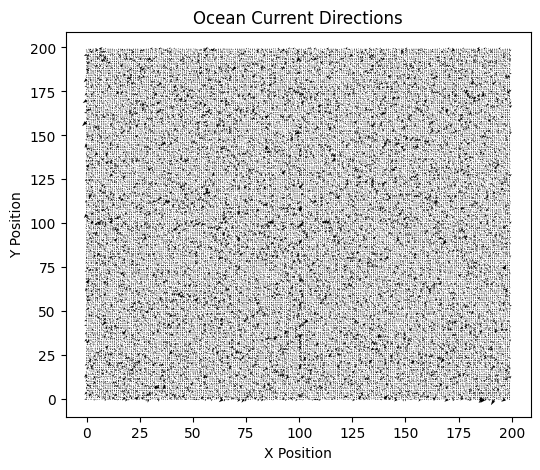

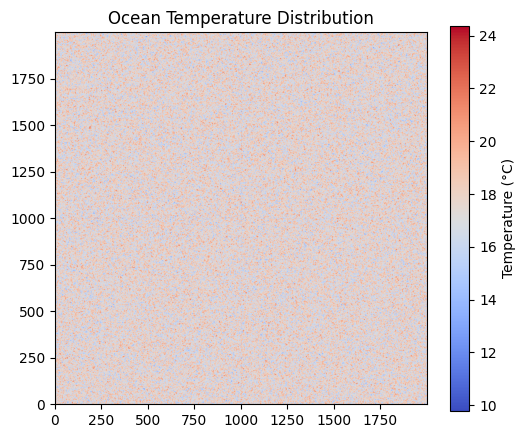

Simulation complete.


In [15]:
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
import time
from dask.distributed import Client

# Grid parameters
grid_size = 2000
TIME_STEPS = 100

# Initialize fields as Dask arrays with chunking
# chunk_size = (500, 500)
chunk_size = (1000, 1000)
# chunk_size = (2000, 2000)
temperature = da.random.uniform(5, 30, size=(grid_size, grid_size), chunks=chunk_size)
u_velocity = da.random.uniform(-1, 1, size=(grid_size, grid_size), chunks=chunk_size)
v_velocity = da.random.uniform(-1, 1, size=(grid_size, grid_size), chunks=chunk_size)
wind = da.random.uniform(-0.5, 0.5, size=(grid_size, grid_size), chunks=chunk_size)

def compute_laplacian(field):
    """Compute Laplacian using Dask map_overlap with periodic boundaries."""
    return da.map_overlap(
        lambda block: (
            np.roll(block, shift=1, axis=0) +
            np.roll(block, shift=-1, axis=0) +
            np.roll(block, shift=1, axis=1) +
            np.roll(block, shift=-1, axis=1) -
            4 * block
        ),
        field,
        depth=1,
        boundary='reflect'
    )

def update_u_blocks(u, wind, alpha=0.1, beta=0.02):
    """Update ocean fields using parallelized Dask operations."""
    u = da.asarray(u)
    lap_u = compute_laplacian(u)
    u_new = u + alpha * lap_u + beta * wind
    return u_new

def update_v_blocks(v, wind, alpha=0.1, beta=0.02):
    v = da.asarray(v)
    lap_v = compute_laplacian(v)
    v_new = v + alpha * lap_v + beta * wind
    return v_new

def update_temp_blocks(temp):
    temp = da.asarray(temp)
    lap_temp = compute_laplacian(temp)
    temp_new = temp + 0.01 * lap_temp
    return temp_new

def update_ocean(u, v, temp, wind, alpha=0.1, beta=0.02):
    """Update ocean fields using parallelized Dask operations."""
    u_new = da.map_blocks(
        update_u_blocks,
        u, wind,
        dtype=u.dtype
    )
    v_new = da.map_blocks(
        update_v_blocks,
        v, wind,
        dtype=v.dtype
    )
    temp_new = da.map_blocks(
        update_temp_blocks,
        temp,
        dtype=temp.dtype
    )
    return u_new, v_new, temp_new


if __name__ == "__main__":
    # Run simulation and time it
    start = time.time()

    client = Client(n_workers=8)
    print("Dask Dashboard link:", client.dashboard_link)  # Prints the link to the Dask Dashboard

    for t in range(TIME_STEPS):
        u_velocity, v_velocity, temperature = update_ocean(u_velocity, v_velocity, temperature, wind)
        if t % 8 == 0 or t == TIME_STEPS - 1:
            print(f"Time Step {t}: Updated.")

    # Trigger computation and get final results
    u_final, v_final, temp_final = da.compute(u_velocity, v_velocity, temperature)

    client.close()
    print(f"Execution time: {time.time() - start:.2f} seconds")

    # Visualization
    plt.figure(figsize=(6, 5))
    plt.quiver(u_final[::10, ::10], v_final[::10, ::10])
    plt.title("Ocean Current Directions")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.imshow(temp_final, cmap='coolwarm', origin='lower')
    plt.colorbar(label="Temperature (°C)")
    plt.title("Ocean Temperature Distribution")
    plt.show()
    print("Simulation complete.")

## Task B.2
### Task B.2.1
Task Stream
![Dask_dashboard](Ocean_dask_dashboard1.png)

Workers
![Dask_dashboard](Ocean_dask_dashboard2.png)

![Dask_dashboard](Ocean_dask_dashboard3.png)

### Task B.2.2
**chunk_size = 500 * 500, 7.66s**

Dask Dashboard link: http://127.0.0.1:8787/status
Time Step 0: Updated.
Time Step 8: Updated.
Time Step 16: Updated.
Time Step 24: Updated.
Time Step 32: Updated.
Time Step 40: Updated.
Time Step 48: Updated.
Time Step 56: Updated.
Time Step 64: Updated.
Time Step 72: Updated.
Time Step 80: Updated.
Time Step 88: Updated.
Time Step 96: Updated.
Time Step 99: Updated.
Execution time: 7.66 seconds


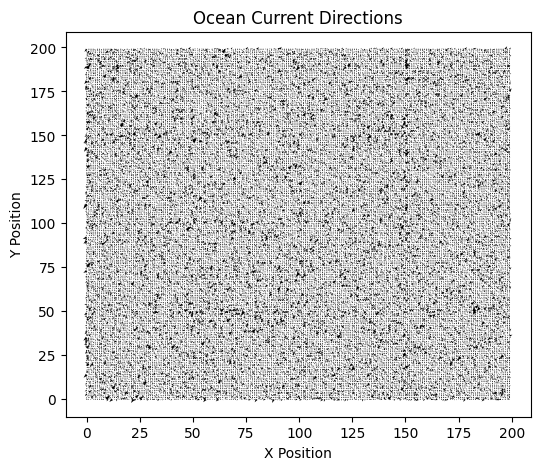

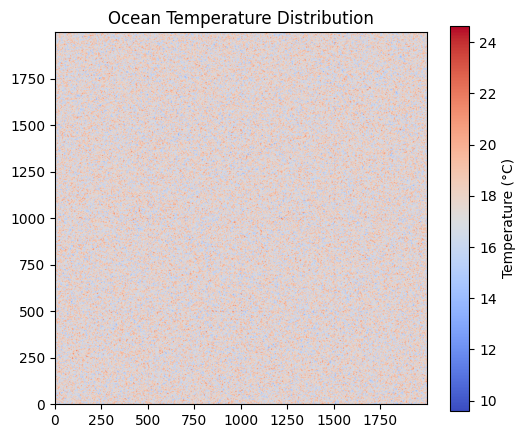

Simulation complete.


In [9]:
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
import time
from dask.distributed import Client

# Grid parameters
grid_size = 2000
TIME_STEPS = 100

# Initialize fields as Dask arrays with chunking
chunk_size = (500, 500)
# chunk_size = (1000, 1000)
# chunk_size = (2000, 2000)
temperature = da.random.uniform(5, 30, size=(grid_size, grid_size), chunks=chunk_size)
u_velocity = da.random.uniform(-1, 1, size=(grid_size, grid_size), chunks=chunk_size)
v_velocity = da.random.uniform(-1, 1, size=(grid_size, grid_size), chunks=chunk_size)
wind = da.random.uniform(-0.5, 0.5, size=(grid_size, grid_size), chunks=chunk_size)

def compute_laplacian(field):
    """Compute Laplacian using Dask map_overlap with periodic boundaries."""
    return da.map_overlap(
        lambda block: (
            np.roll(block, shift=1, axis=0) +
            np.roll(block, shift=-1, axis=0) +
            np.roll(block, shift=1, axis=1) +
            np.roll(block, shift=-1, axis=1) -
            4 * block
        ),
        field,
        depth=1,
        boundary='reflect'
    )

def update_u_blocks(u, wind, alpha=0.1, beta=0.02):
    """Update ocean fields using parallelized Dask operations."""
    u = da.asarray(u)
    lap_u = compute_laplacian(u)
    u_new = u + alpha * lap_u + beta * wind
    return u_new

def update_v_blocks(v, wind, alpha=0.1, beta=0.02):
    v = da.asarray(v)
    lap_v = compute_laplacian(v)
    v_new = v + alpha * lap_v + beta * wind
    return v_new

def update_temp_blocks(temp):
    temp = da.asarray(temp)
    lap_temp = compute_laplacian(temp)
    temp_new = temp + 0.01 * lap_temp
    return temp_new

def update_ocean(u, v, temp, wind, alpha=0.1, beta=0.02):
    """Update ocean fields using parallelized Dask operations."""
    u_new = da.map_blocks(
        update_u_blocks,
        u, wind,
        dtype=u.dtype
    )
    v_new = da.map_blocks(
        update_v_blocks,
        v, wind,
        dtype=v.dtype
    )
    temp_new = da.map_blocks(
        update_temp_blocks,
        temp,
        dtype=temp.dtype
    )
    return u_new, v_new, temp_new


if __name__ == "__main__":
    # Run simulation and time it
    start = time.time()

    client = Client(n_workers=8)
    print("Dask Dashboard link:", client.dashboard_link)  # Prints the link to the Dask Dashboard

    for t in range(TIME_STEPS):
        u_velocity, v_velocity, temperature = update_ocean(u_velocity, v_velocity, temperature, wind)
        if t % 8 == 0 or t == TIME_STEPS - 1:
            print(f"Time Step {t}: Updated.")

    # Trigger computation and get final results
    u_final, v_final, temp_final = da.compute(u_velocity, v_velocity, temperature)

    client.close()
    print(f"Execution time: {time.time() - start:.2f} seconds")

    # Visualization
    plt.figure(figsize=(6, 5))
    plt.quiver(u_final[::10, ::10], v_final[::10, ::10])
    plt.title("Ocean Current Directions")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.imshow(temp_final, cmap='coolwarm', origin='lower')
    plt.colorbar(label="Temperature (°C)")
    plt.title("Ocean Temperature Distribution")
    plt.show()
    print("Simulation complete.")

**chunk size = 1000 * 1000, 4.24s**

Dask Dashboard link: http://127.0.0.1:8787/status
Time Step 0: Updated.
Time Step 8: Updated.
Time Step 16: Updated.
Time Step 24: Updated.
Time Step 32: Updated.
Time Step 40: Updated.
Time Step 48: Updated.
Time Step 56: Updated.
Time Step 64: Updated.
Time Step 72: Updated.
Time Step 80: Updated.
Time Step 88: Updated.
Time Step 96: Updated.
Time Step 99: Updated.
Execution time: 4.24 seconds


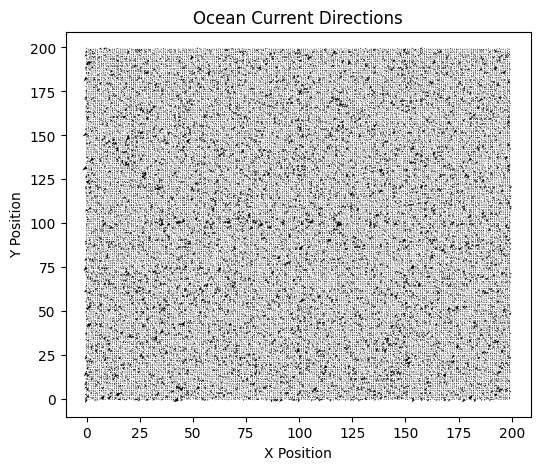

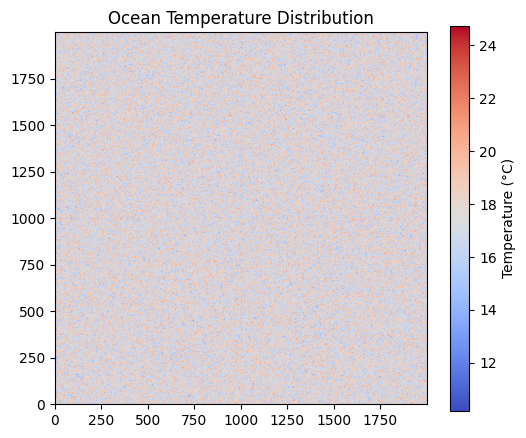

Simulation complete.


In [8]:
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
import time
from dask.distributed import Client

# Grid parameters
grid_size = 2000
TIME_STEPS = 100

# Initialize fields as Dask arrays with chunking
# chunk_size = (500, 500)
chunk_size = (1000, 1000)
# chunk_size = (2000, 2000)
temperature = da.random.uniform(5, 30, size=(grid_size, grid_size), chunks=chunk_size)
u_velocity = da.random.uniform(-1, 1, size=(grid_size, grid_size), chunks=chunk_size)
v_velocity = da.random.uniform(-1, 1, size=(grid_size, grid_size), chunks=chunk_size)
wind = da.random.uniform(-0.5, 0.5, size=(grid_size, grid_size), chunks=chunk_size)

def compute_laplacian(field):
    """Compute Laplacian using Dask map_overlap with periodic boundaries."""
    return da.map_overlap(
        lambda block: (
            np.roll(block, shift=1, axis=0) +
            np.roll(block, shift=-1, axis=0) +
            np.roll(block, shift=1, axis=1) +
            np.roll(block, shift=-1, axis=1) -
            4 * block
        ),
        field,
        depth=1,
        boundary='reflect'
    )

def update_u_blocks(u, wind, alpha=0.1, beta=0.02):
    """Update ocean fields using parallelized Dask operations."""
    u = da.asarray(u)
    lap_u = compute_laplacian(u)
    u_new = u + alpha * lap_u + beta * wind
    return u_new

def update_v_blocks(v, wind, alpha=0.1, beta=0.02):
    v = da.asarray(v)
    lap_v = compute_laplacian(v)
    v_new = v + alpha * lap_v + beta * wind
    return v_new

def update_temp_blocks(temp):
    temp = da.asarray(temp)
    lap_temp = compute_laplacian(temp)
    temp_new = temp + 0.01 * lap_temp
    return temp_new

def update_ocean(u, v, temp, wind, alpha=0.1, beta=0.02):
    """Update ocean fields using parallelized Dask operations."""
    u_new = da.map_blocks(
        update_u_blocks,
        u, wind,
        dtype=u.dtype
    )
    v_new = da.map_blocks(
        update_v_blocks,
        v, wind,
        dtype=v.dtype
    )
    temp_new = da.map_blocks(
        update_temp_blocks,
        temp,
        dtype=temp.dtype
    )
    return u_new, v_new, temp_new


if __name__ == "__main__":
    # Run simulation and time it
    start = time.time()

    client = Client(n_workers=8)
    print("Dask Dashboard link:", client.dashboard_link)  # Prints the link to the Dask Dashboard

    for t in range(TIME_STEPS):
        u_velocity, v_velocity, temperature = update_ocean(u_velocity, v_velocity, temperature, wind)
        if t % 8 == 0 or t == TIME_STEPS - 1:
            print(f"Time Step {t}: Updated.")

    # Trigger computation and get final results
    u_final, v_final, temp_final = da.compute(u_velocity, v_velocity, temperature)

    client.close()
    print(f"Execution time: {time.time() - start:.2f} seconds")

    # Visualization
    plt.figure(figsize=(6, 5))
    plt.quiver(u_final[::10, ::10], v_final[::10, ::10])
    plt.title("Ocean Current Directions")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.imshow(temp_final, cmap='coolwarm', origin='lower')
    plt.colorbar(label="Temperature (°C)")
    plt.title("Ocean Temperature Distribution")
    plt.show()
    print("Simulation complete.")

**chunk_size = 2000 * 2000, 4.89s**

Dask Dashboard link: http://127.0.0.1:8787/status
Time Step 0: Updated.
Time Step 8: Updated.
Time Step 16: Updated.
Time Step 24: Updated.
Time Step 32: Updated.
Time Step 40: Updated.
Time Step 48: Updated.
Time Step 56: Updated.
Time Step 64: Updated.
Time Step 72: Updated.
Time Step 80: Updated.
Time Step 88: Updated.
Time Step 96: Updated.
Time Step 99: Updated.
Execution time: 4.89 seconds


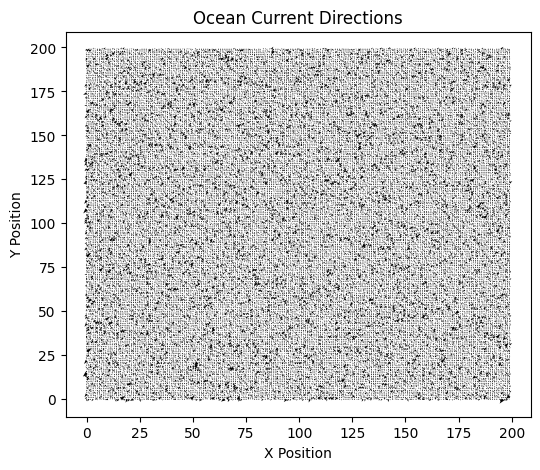

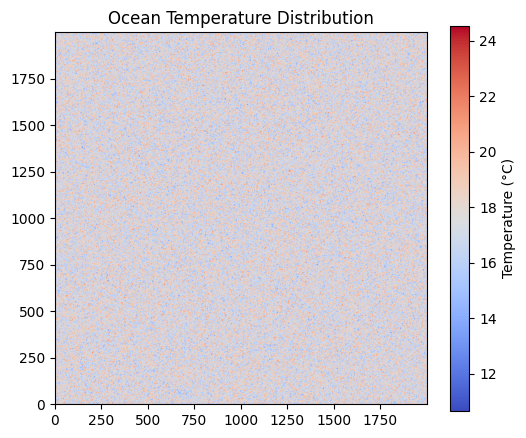

Simulation complete.


In [10]:
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
import time
from dask.distributed import Client

# Grid parameters
grid_size = 2000
TIME_STEPS = 100

# Initialize fields as Dask arrays with chunking
# chunk_size = (500, 500)
# chunk_size = (1000, 1000)
chunk_size = (2000, 2000)
temperature = da.random.uniform(5, 30, size=(grid_size, grid_size), chunks=chunk_size)
u_velocity = da.random.uniform(-1, 1, size=(grid_size, grid_size), chunks=chunk_size)
v_velocity = da.random.uniform(-1, 1, size=(grid_size, grid_size), chunks=chunk_size)
wind = da.random.uniform(-0.5, 0.5, size=(grid_size, grid_size), chunks=chunk_size)

def compute_laplacian(field):
    """Compute Laplacian using Dask map_overlap with periodic boundaries."""
    return da.map_overlap(
        lambda block: (
            np.roll(block, shift=1, axis=0) +
            np.roll(block, shift=-1, axis=0) +
            np.roll(block, shift=1, axis=1) +
            np.roll(block, shift=-1, axis=1) -
            4 * block
        ),
        field,
        depth=1,
        boundary='reflect'
    )

def update_u_blocks(u, wind, alpha=0.1, beta=0.02):
    """Update ocean fields using parallelized Dask operations."""
    u = da.asarray(u)
    lap_u = compute_laplacian(u)
    u_new = u + alpha * lap_u + beta * wind
    return u_new

def update_v_blocks(v, wind, alpha=0.1, beta=0.02):
    v = da.asarray(v)
    lap_v = compute_laplacian(v)
    v_new = v + alpha * lap_v + beta * wind
    return v_new

def update_temp_blocks(temp):
    temp = da.asarray(temp)
    lap_temp = compute_laplacian(temp)
    temp_new = temp + 0.01 * lap_temp
    return temp_new

def update_ocean(u, v, temp, wind, alpha=0.1, beta=0.02):
    """Update ocean fields using parallelized Dask operations."""
    u_new = da.map_blocks(
        update_u_blocks,
        u, wind,
        dtype=u.dtype
    )
    v_new = da.map_blocks(
        update_v_blocks,
        v, wind,
        dtype=v.dtype
    )
    temp_new = da.map_blocks(
        update_temp_blocks,
        temp,
        dtype=temp.dtype
    )
    return u_new, v_new, temp_new


if __name__ == "__main__":
    # Run simulation and time it
    start = time.time()

    client = Client(n_workers=8)
    print("Dask Dashboard link:", client.dashboard_link)  # Prints the link to the Dask Dashboard

    for t in range(TIME_STEPS):
        u_velocity, v_velocity, temperature = update_ocean(u_velocity, v_velocity, temperature, wind)
        if t % 8 == 0 or t == TIME_STEPS - 1:
            print(f"Time Step {t}: Updated.")

    # Trigger computation and get final results
    u_final, v_final, temp_final = da.compute(u_velocity, v_velocity, temperature)

    client.close()
    print(f"Execution time: {time.time() - start:.2f} seconds")

    # Visualization
    plt.figure(figsize=(6, 5))
    plt.quiver(u_final[::10, ::10], v_final[::10, ::10])
    plt.title("Ocean Current Directions")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.imshow(temp_final, cmap='coolwarm', origin='lower')
    plt.colorbar(label="Temperature (°C)")
    plt.title("Ocean Temperature Distribution")
    plt.show()
    print("Simulation complete.")

So chunk_size = (1000, 1000) is the best

### Task 2.3

**How well-balanced were the worker loads?**
![Dask_dashboard](Ocean_dask_dashboard4.png)
The worker loads are well-balanced, with CPU usage and memory usage remaining within acceptable limits. No worker appears overloaded or underutilized.

**Did any worker run out of memory?**

No worker ran out of memory. Memory usage across workers remained well within the allocated limits(10% - 20%).


**Was there idle time or task queuing?**

There was minimal task queuing, and no significant idle time was observed. Tasks were processed efficiently, with no long wait times or significant backlogs.